<a href="https://colab.research.google.com/github/DGendooLab/scGPT-GBM-classifier/blob/main/testing_examples/TESTING_DOWNSAMPLE_scGPT_Embedding_Tasks_GBM_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Glioblastoma scGPT Classifier (Downsampled Analysis)
Only intended for testing with T4 Free tier GPU

## Introduction

Based off the
[scGPT GitHub](https://www.github.com/bowang-lab/scGPT/blob/main/tutorials/zero-shot/Tutorial_ZeroShot_Reference_Mapping.ipynb/) tutorial.

### IMPORTANT:
Connect to a runtime (T4 GPU for free tier) then:

__Tools -> Command Pallete -> "Use fallback runtime version" as scGPT is currently only available for Python<3.11 and Google Colab has been updated to Python 3.11__  

With Google Colab Pro - Use L4 GPU (cheaper) or A100 GPU (faster for embedding tasks).

Use the scGPT-GBM workflow for T4 GPU (Google Colab Free) if you want to test without a subscription.

Pip Freeze Packages (Python 3.10.12) -> LAST CELL OF NOTEBOOK

In [1]:
# connecting to your own google drive (not mandatory unless you want to generate UMAPs in the Post Processing script)

from google.colab import drive
drive.mount('/content/drive')

!python3 --version # should return Python 3.10.12, if not make sure to follow instructions above to "Use Fallback Version"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Python 3.10.12


In [2]:
import os
import sys
import requests

if "google.colab" in sys.modules:
    print("Running on Google Colab")
    print("Installing dependencies...")

    !pip install --upgrade scgpt
    !pip install wandb louvain faiss-gpu

    # Install wget for downloading files from URLs
    !apt-get install wget

    # Install gdown for Google Drive downloads
    !pip install -q -U gdown

    print("Downloading scGPT model checkpoint via Google Drive...")
    model_dir = "/content/save/scGPT_continual"
    if not os.path.exists(model_dir):
        !mkdir -p $model_dir
        import gdown
        gdown.download_folder(
            #  human 33M
            # "https://drive.google.com/drive/folders/1oWh_-ZRdhtoGQ2Fw24HP41FgLoomVo-y",

            # brain 10M
            # "https://drive.google.com/drive/folders/1vf1ijfQSk7rGdDGpBntR5bi5g6gNt-Gx",

            # continual pretrained (batch corrected)
            "https://drive.google.com/drive/folders/1_GROJTzXiAV8HB4imruOTk6PEGuNOcgB",
            output=model_dir,
            quiet=False
        )

    print("Setup complete!")

Running on Google Colab
Installing dependencies...
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
wget is already the newest version (1.21.2-2ubuntu1.1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Setup complete!


In [3]:
print("Downloading Richards et al 2021 GBM data and GBMAP filtered data via Google Drive...")

data_dir = "/content/data"
if not os.path.exists(data_dir):
    os.mkdir(data_dir)
    # from google drive folder

    gdown.download_folder(
        "https://drive.google.com/drive/folders/1LfHupXfZPAcLj-xyttfIHsl0FAHlGKUJ",
        output=os.path.join(data_dir),
    )


## Import scGPT and dependencies

In [5]:
from pathlib import Path
import numpy as np
from scipy.stats import mode
import scanpy as sc
import warnings
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import sys

sys.path.insert(0, "../")

import scgpt as scg

# extra dependency for similarity search
try:
    import faiss

    faiss_imported = True
    print("faiss imported!")
    print(faiss.__version__)

except ImportError:
    faiss_imported = False
    print(
        "faiss not installed! We highly recommend installing it for fast similarity search."
    )
    print("To install it, see https://github.com/facebookresearch/faiss/wiki/Installing-Faiss")

warnings.filterwarnings("ignore", category=ResourceWarning)
warnings.filterwarnings("ignore", category=ImportWarning)


faiss imported!
1.7.2


## Loading Data
Downloaded data can be found in cells above or [here](https://drive.google.com/drive/folders/1LfHupXfZPAcLj-xyttfIHsl0FAHlGKUJ)

In [9]:
import numpy as np

# Reading in data
gbmap = sc.read_h5ad("/content/data/gbm_filtered.h5ad")
# adata_train = gbmap

# Keep only the relevant columns in obs (cell metadata)
gbmap.obs = gbmap.obs[['author', 'annotation_level_3', 'cell_type']]

# Keep only the relevant columns in var (gene metadata)
gbmap.var = gbmap.var[['feature_name']]

# Remove unwanted attributes
gbmap.raw = None  # Remove raw data if not needed
gbmap.layers.clear()  # Remove all layers
gbmap.uns.clear()  # Remove unstructured data
gbmap.obsm.clear()  # Remove dimensional reductions
gbmap.varm.clear()  # Remove gene-related matrices
gbmap.obsp.clear()  # Remove pairwise similarity matrices

# Downsample gbmap
# Set seed for reproducibility
np.random.seed(42)

# Remove Neftel2019 data to prevent overfitting in predictions
filtered_indices = gbmap.obs["author"] != "Neftel2019"
gbmap = gbmap[filtered_indices]  # Avoids a deep copy

# Subset 25% of the cells randomly
subset_indices = np.random.choice(gbmap.n_obs, size=int(0.25 * gbmap.n_obs), replace=False)

# Subset the AnnData object
adata_train = gbmap[subset_indices, :].copy()
del gbmap

neftel = sc.read_h5ad("/content/data/neftel/Neftel2019_data.h5ad")
neftel.X = neftel.raw.X.copy()
neftel.raw = None
adata_test = neftel
del neftel

cell_type_key = "annotation_level_3"
# cell_type_key = "cell_type"
gene_col = "feature_name"

# Print the number of cells for adata_train and adata_test
num_cells_train = adata_train.n_obs
print(f"Number of cells - adata_train: {num_cells_train}")

num_cells_test = adata_test.n_obs
print(f"Number of cells - adata_test: {num_cells_test}")

import torch
batch_size=int(torch.cuda.get_device_properties(0).total_memory/1e9+.5)*16
print(f'GPU mem:{int(torch.cuda.get_device_properties(0).total_memory/1e9+.5)}G, batch_size:{batch_size}')


Number of cells - adata_train: 69762
Number of cells - adata_test: 19030
GPU mem:16G, batch_size:256


In [10]:
# Get the counts of each cell type in 'annotation_level_3'
cell_type_counts = adata_train.obs['annotation_level_3'].value_counts()

# Print the counts
print(cell_type_counts)

annotation_level_3
CD4/CD8            13425
TAM-BDM            12843
AC-like             9633
TAM-MG              9208
MES-like            7371
NPC-like            4678
OPC-like            3762
Mono                3353
Oligodendrocyte     2154
DC                   892
RG                   715
NK                   604
B cell               316
Mural cell           314
Endothelial          151
OPC                  121
Plasma B             104
Mast                  68
Astrocyte             45
Neuron                 5
Name: count, dtype: int64


In [11]:
# Clear memory
import gc
gc.collect()

347


REFERENCE SCGPT EMBEDDING

In [12]:
%%time
!pip install --upgrade PyDrive2

# import warnings
# warnings.filterwarnings("ignore", category=ImportWarning)

ref_embed_adata = scg.tasks.embed_data(
    adata_train,
    model_dir,
    gene_col=gene_col,
    batch_size=batch_size,
    device="cuda",
    use_fast_transformer=False,
)


scGPT - INFO - match 22864/27983 genes in vocabulary of size 60697.


Embedding cells: 100%|██████████| 273/273 [13:52<00:00,  3.05s/it]
/usr/local/lib/python3.10/dist-packages/scgpt/tasks/cell_emb.py:279: ImplicitModificationWarning: Setting element `.obsm['X_scGPT']` of view, initializing view as actual.
  adata.obsm["X_scGPT"] = cell_embeddings


CPU times: user 13min 21s, sys: 10.9 s, total: 13min 32s
Wall time: 14min 10s


In [13]:
# Clear memory
del adata_train
gc.collect()

164


QUERY SCGPT EMBEDDING

In [14]:
%%time

!pip install --upgrade PyDrive2

# import warnings
# warnings.filterwarnings("ignore", category=ImportWarning)

test_embed_adata = scg.tasks.embed_data(
    adata_test,
    model_dir,
    gene_col=gene_col,
    batch_size=batch_size,
    device="cuda",
    use_fast_transformer=False,
)

scGPT - INFO - match 22864/27983 genes in vocabulary of size 60697.


Embedding cells: 100%|██████████| 75/75 [03:48<00:00,  3.05s/it]
/usr/local/lib/python3.10/dist-packages/scgpt/tasks/cell_emb.py:279: ImplicitModificationWarning: Setting element `.obsm['X_scGPT']` of view, initializing view as actual.
  adata.obsm["X_scGPT"] = cell_embeddings


CPU times: user 3min 54s, sys: 6.3 s, total: 4min
Wall time: 4min 21s


QUERY CELL TYPE MASKING

In [15]:
# concatenate the two datasets
adata_concat = test_embed_adata.concatenate(ref_embed_adata, batch_key="dataset")
# mark the reference vs. query dataset
adata_concat.obs["is_ref"] = ["Query"] * len(test_embed_adata) + ["Reference"] * len(
    ref_embed_adata
)
adata_concat.obs["is_ref"] = adata_concat.obs["is_ref"].astype("category")
# mask the query dataset cell types
adata_concat.obs[cell_type_key] = adata_concat.obs[cell_type_key].astype("category")
adata_concat.obs[cell_type_key] = adata_concat.obs[cell_type_key].cat.add_categories(["To be predicted"])
adata_concat.obs[cell_type_key][: len(test_embed_adata)] = "To be predicted"

<ipython-input-15-e57926d27f57>:2: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_concat = test_embed_adata.concatenate(ref_embed_adata, batch_key="dataset")
<ipython-input-15-e57926d27f57>:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and en

In [16]:
# from google.colab import drive
# drive.mount('/content/drive')

# saving concatenated files for post-processing UMAPs
adata_concat.write('/content/drive/My Drive/Neftel_test_GBMAP_train_embed_full_concat.h5ad')

# temp files for re-runs --- write
# ref_embed_adata.write('/content/drive/My Drive/GBMAP_train_embed_ref.h5ad')
# test_embed_adata.write('/content/drive/My Drive/Neftel_test_embed_query.h5ad')

# temp files for re-runs --- read
# ref_embed_adata = sc.read_h5ad('/content/drive/My Drive/GBMAP_train_embed_ref.h5ad')
# test_embed_adata = sc.read_h5ad('/content/drive/My Drive/Neftel_test_embed_query.h5ad')

## Reference mapping and transfer the annotations

We run the reference mapping using cell-level majority voting. You may adjust the `k` parameter to control the number of nearest neighbors to consider for voting.

In [18]:
# Those functions are only used when faiss is not installed
# Compute L2 similarity (negative Euclidean distance) between a vector and reference vectors
def l2_sim(a, b):
    sims = -np.linalg.norm(a - b, axis=1)
    return sims

# Retrieve the top-k most similar vectors from the reference set
def get_similar_vectors(vector, ref, top_k=10):
        # sims = cos_sim(vector, ref)
        # Calculate similarities (using L2 distance)
        sims = l2_sim(vector, ref)

        # Get indices of the top-k highest similarity scores
        top_k_idx = np.argsort(sims)[::-1][:top_k]
        return top_k_idx, sims[top_k_idx]

In [19]:
%%time
warnings.simplefilter(action='ignore', category=FutureWarning)

# Extract embeddings from reference and test datasets
ref_cell_embeddings = ref_embed_adata.obsm["X_scGPT"]
test_embed = test_embed_adata.obsm["X_scGPT"]
cell_type_key = "annotation_level_3" # Key for cell type annotations

k = 10  # Number of nearest neighbors to consider

# Create a FAISS index for the reference embeddings and add data to it
index = faiss.IndexFlatL2(ref_cell_embeddings.shape[1])
index.add(ref_cell_embeddings)

# Perform a k-nearest neighbor search for the test embeddings
distances, labels = index.search(test_embed, k)

# Predict cell types for each test embedding
idx_list=[i for i in range(test_embed.shape[0])]
preds = []
sim_list = distances
for k in idx_list:
    if faiss_imported:
        idx = labels[k]
    else:
        idx, sim = get_similar_vectors(test_embed[k][np.newaxis, ...], ref_cell_embeddings, k)
    pred = ref_embed_adata.obs[cell_type_key][idx].value_counts()
    preds.append(pred.index[0])

# Store the predicted cell types in the test dataset
test_embed_adata.obs["predicted_cell_type"] = preds

# Ground truth cell types for comparison
gt = adata_test.obs[cell_type_key].to_numpy()

CPU times: user 37 s, sys: 619 ms, total: 37.6 s
Wall time: 40.8 s


In [20]:
# Saving new test_embed_adata with predictions to calculate ARI and plot on UMAP in post-processing scripts (optional)
test_embed_adata.write('/content/drive/My Drive/Neftel_test_embed_query_preds.h5ad')

## Performance Metrics

In [21]:
res_dict = {
    "accuracy": accuracy_score(gt, preds),
    "precision": precision_score(gt, preds, average="macro"),
    "recall": recall_score(gt, preds, average="macro"),
    "macro_f1": f1_score(gt, preds, average="macro"),
}

res_dict

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'accuracy': 0.5861271676300578,
 'precision': 0.5935261626433713,
 'recall': 0.4537162585780575,
 'macro_f1': 0.48112567763070213}

## Plotting Confusion Matrix (True vs Predicted)

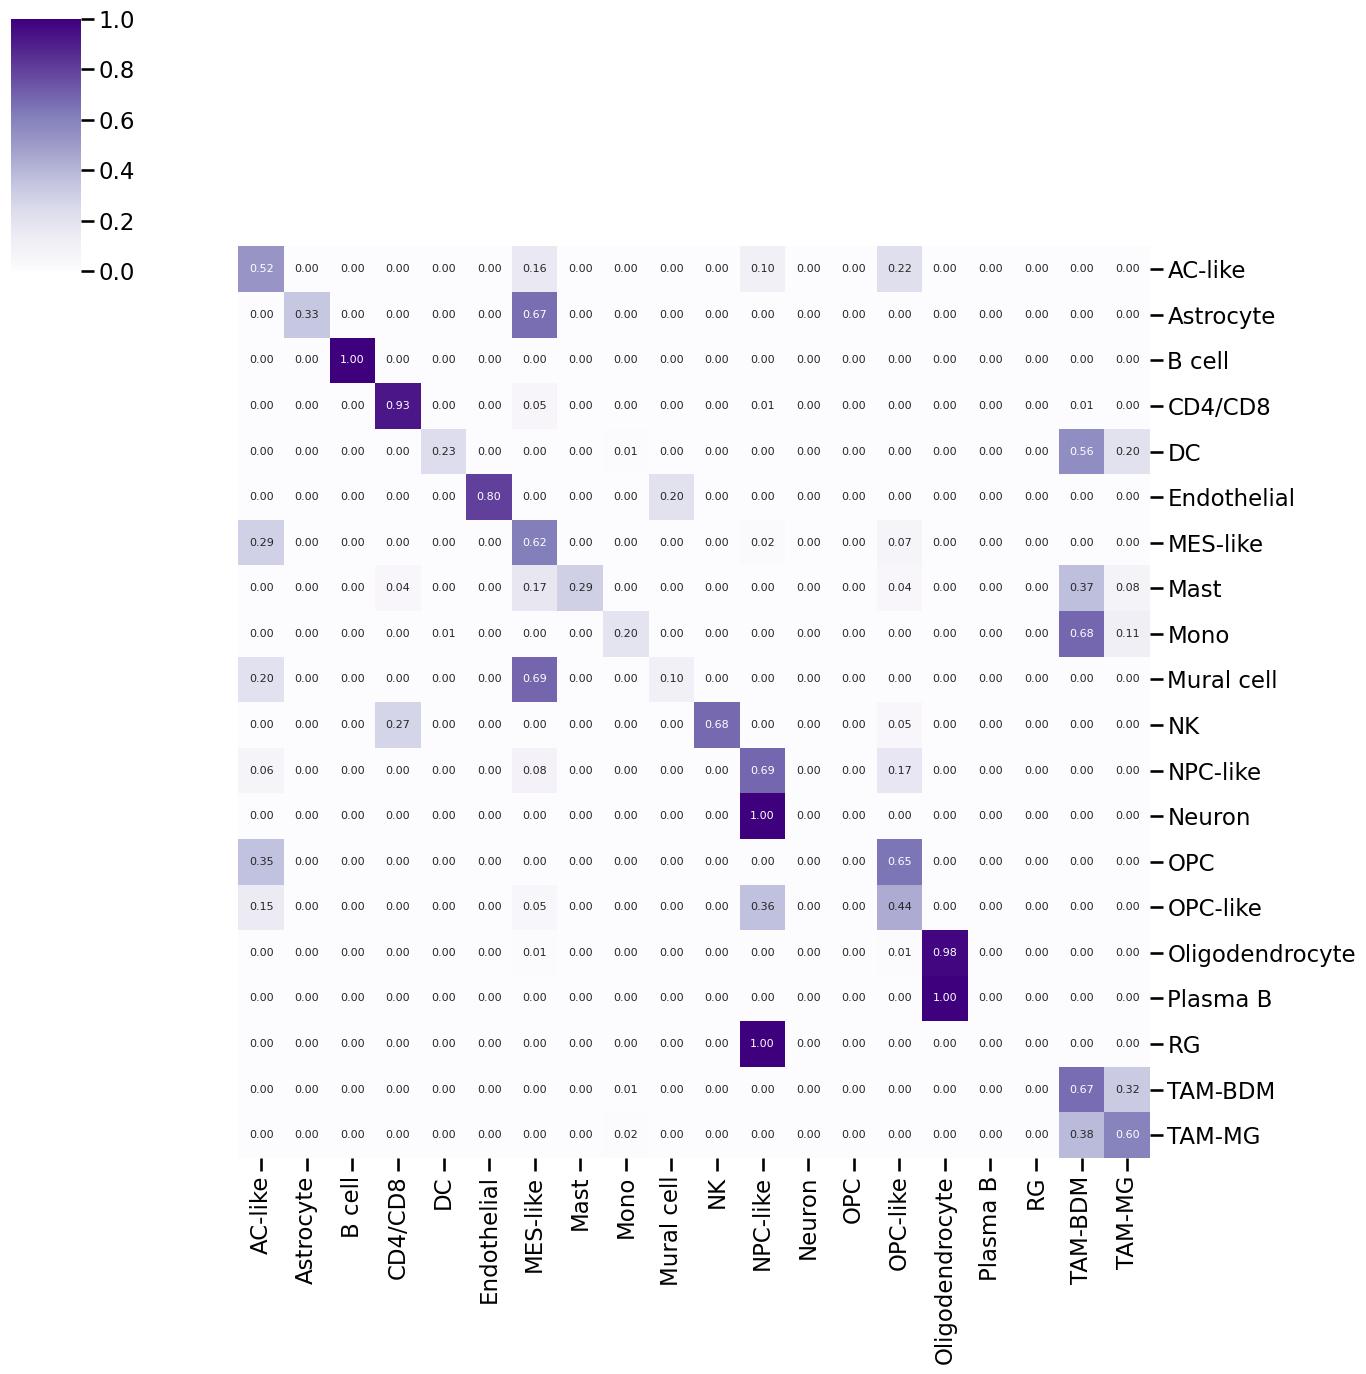

In [22]:
# Extract true labels and predicted labels
y_true = adata_test.obs[cell_type_key].to_numpy()
y_pred = preds

# Create a list of unique cell types and compute the confusion matrix
cell_type_list = np.unique(y_true)
matrix = confusion_matrix(y_true, y_pred, labels=cell_type_list)

# Normalize the confusion matrix to calculate proportions
matrix = matrix.astype("float") / matrix.sum(axis=1)[:, np.newaxis]

# Convert the matrix to a Pandas DataFrame for visualization
df = pd.DataFrame(matrix, index=cell_type_list[:matrix.shape[0]], columns=cell_type_list[:matrix.shape[1]])

# Generate a heatmap of the confusion matrix
ax = sns.clustermap(
    df,
    cmap='Purples',              # Colour map
    annot=True,                  # Add value annotations
    fmt=".2f",                   # Format annotations to two decimals
    annot_kws={'size': 8},       # Annotation font size
    vmin=0, vmax=1,              # Normalize colormap between 0 and 1
    row_cluster=False,           # Disable row clustering
    col_cluster=False,           # Disable column clustering
    figsize=(14, 14)             # Set figure size
)

## Pip Freeze Packages (Python 3.10.12):

In [ ]:
pip freeze

absl-py==1.4.0
accelerate==1.2.1
aiohappyeyeballs==2.4.4
aiohttp==3.11.10
aiosignal==1.3.2
alabaster==1.0.0
albucore==0.0.19
albumentations==1.4.20
altair==5.5.0
anndata==0.11.3
annotated-types==0.7.0
anyio==3.7.1
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array_api_compat==1.10.0
array_record==0.5.1
arviz==0.20.0
astropy==6.1.7
astropy-iers-data==0.2024.12.16.0.35.48
astunparse==1.6.3
async-timeout==4.0.3
atpublic==4.1.0
attrs==24.3.0
audioread==3.0.1
autograd==1.7.0
babel==2.16.0
backcall==0.2.0
beautifulsoup4==4.12.3
bigframes==1.29.0
bigquery-magics==0.4.0
bleach==6.2.0
blinker==1.9.0
blis==0.7.11
blosc2==2.7.1
bokeh==3.6.2
Bottleneck==1.4.2
bqplot==0.12.43
branca==0.8.1
CacheControl==0.14.1
cached-property==2.0.1
cachetools==5.5.0
catalogue==2.0.10
cell-gears==0.0.2
certifi==2024.12.14
cffi==1.17.1
chardet==5.2.0
charset-normalizer==3.4.0
chex==0.1.88
clarabel==0.9.0
click==8.1.7
cloudpathlib==0.20.0
cloudpickle==3.1.0
cmake==3.31.2
cmdstanpy==1.2.5
colorcet==3.1.0
colorlove

## Data sources (GBMAP)

In [ ]:
# GBMAP datasets: https://cellxgene.cziscience.com/collections/999f2a15-3d7e-440b-96ae-2c806799c08c

# dataset_url = "https://datasets.cellxgene.cziscience.com/95681969-4e6d-4ba7-9854-645308b451e2.h5ad"
# output_path = os.path.join(data_dir, "gbmap.h5ad")
# !wget -O {output_path} "{dataset_url}"

# # URL of the extended GBmap dataset
# url = 'https://datasets.cellxgene.cziscience.com/d36a23ec-65f6-446e-8e69-c72ccbd44d9e.h5ad'

# # Path to save the dataset
# file_path = os.path.join(data_dir, "gbmap", 'extended_gbmap.h5ad')

# # Download the dataset
# !wget -O {file_path} {url}